In [1]:
# All dependencies
!pip install xlrd

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import requests
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from os import path
from time import time
from mpl_toolkits.mplot3d import Axes3D as plt3

**Commonly Used Methods**

The methods below are commonly used when running a variety of classification and regression models.

In [2]:
def dataframe_from_csv(file_name, exclude_cols):
    cols = list(pd.read_csv(f"{file_name}.csv", nrows=1))

    return pd.read_csv(f"{file_name}.csv", usecols=[a for a in cols if a not in exclude_cols])

def get_accuracy(y_test, y_pred, use_np_mean=False):
    if use_np_mean:
        accuracy = np.mean(y_test == y_pred)
    else:
        accuracy = np.dot(y_test, y_pred) / (la.norm(y_test) * la.norm(y_pred))
    
    return float(f"{accuracy * 100:.3f}")

**Downloading of the Data Files**

We used dropbox to store the CSV files and used their urls to load them into pandas Dataframes using our custom method `dataframe_from_csv`.

In [3]:
# Download data files
urls = {
    "vehicles": "https://www.dropbox.com/scl/fi/rfywugpl0vxo5mc5b7uy7/Vehicles0514.csv?rlkey=v4yygd6hc96ejfm9nt1fvadz9&dl=0",
    "casualties": "https://www.dropbox.com/scl/fi/o1ljw70bzrwmx0x8etifq/Casualties0514.csv?rlkey=iwyg1ergtazhl6mgwqk78xn5s&dl=0",
    "accidents": "https://www.dropbox.com/scl/fi/7enn6tyaavc8ch8hlib0f/Accidents0514.csv?rlkey=u316i9rln87722m1fefzfp5ba&dl=0",
    "data-guide": "https://www.dropbox.com/scl/fi/amogx0ugusmivneq6ardz/Road-Accident-Safety-Data-Guide.xls?rlkey=rnkxrf6eqjer67x2lv99tzvvv&dl=0"
}

data_frames = {}

# pd.read_excel(urls["data-guide"], sheet_name="Export Variables", engine="xlrd")

exclude_columns = ["Accident_Index", "LSOA_of_Accident_Location"]
for file_name in list(urls.keys())[:-1]:
    print(f"Loading {file_name}.csv")
    if path.exists(f"{file_name}.csv"):
        data_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)
        continue
        
    direct_url = urls[file_name].replace("&dl=0", "&dl=1")
    response = requests.get(direct_url)

    with open(f"{file_name}.csv", "wb") as f:
        f.write(response.content)
        print(f"Wrote {file_name}.csv")

    data_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)

print("Done!")

Loading vehicles.csv
Loading casualties.csv
Loading accidents.csv
Done!


**Plotting and Predicting**

The `plot_ftrs` function creates a scatterplot of the data.  The `fit_predict` function takes in a pipeline and a desired amount of train-test splits, trains the pipeline, and records accuracy while keeping track of the time.

In [4]:
def plot_ftrs(X, y, dimensions=2, cmap="viridis"):
    components = PCA(n_components=(dimensions)).fit(X).transform(X)
    if dimensions == 2:
        fig = plt.figure().add_subplot(111)
        scatter = fig.scatter(components[:, 0], components[:, 1], c=y, cmap=cmap)
    else:
        fig = plt.figure().add_subplot(111, projection="3d")
        scatter = fig.scatter(components[:, 0], components[:, 1], components[:, 2], c=y, cmap=cmap)
    
    plt.colorbar(scatter, ax=fig, ticks=list(np.unique(y)))
    plt.show()

def fit_predict(pipe, tt_splits, params={}, timed=True):
    num_fit_iters = 0
    if timed: start_time = time()
    X_train, X_test, y_train, y_test = tt_splits

    for key in params.keys():
        num_fit_iters += len(params[key])
        if key == "C":
            for val in params[key]:
                print(f"Fitting {key} = {val}")
                pipe.set_params(svc__C=val)

                pipe.fit(X_train, y_train)
                print(f"Accuracy = {get_accuracy(y_test, accident_pipe.predict(X_test))}%")

            if timed: print(f"\nFitting hyperparameter {key} over {len(params[key])} params took {(time() - start_time) / 60:.3f} minutes")
            return

    print("No custom params, fitting default...")
    pipe.fit(X_train, y_train)
    print(f"Accuracy = {get_accuracy(y_test, accident_pipe.predict(X_test))}%")
    if timed: print(f"\nFitting default took {(time() - start_time) / 60:.3f} minutes")
        

**Culling the Accidents Data**

In the `accidents.csv` file, we found that there was too much data accidents of severity 2 and three recorded, leading to nearly unreadable graphs and an unusually high accuracy.  As a result, a method was created to ensure the number of all accidents was roughly even across all severities.

In [5]:
def cull_accidents_data(features, num_of_used_labels = 64146):
    accident_data = data_frames["accidents"][features].dropna().values
    np.random.shuffle(accident_data)

    sev_three = accident_data[accident_data[:, -1] == 3][:(int(num_of_used_labels / 3)), :]
    sev_two = accident_data[accident_data[:, -1] == 2][:(int(num_of_used_labels / 3)), :]
    sev_one = accident_data[accident_data[:, -1] == 1][:(int(num_of_used_labels / 3)), :]

    accident_data = np.vstack((sev_one, sev_two, sev_three))
    np.random.shuffle(accident_data)
    return accident_data

In [6]:
accident_data = cull_accidents_data(
    ["Weather_Conditions", "Road_Surface_Conditions", "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"],
    64146
)

In [7]:
"""weather_conditions = ["Weather_Conditions", "Road_Surface_Conditions",
                      "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"]
accident_data = data_frames["accidents"][weather_conditions].dropna().values
np.random.shuffle(accident_data)

sev_three = accident_data[accident_data[:, -1] == 3][:21382, :]
sev_two = accident_data[accident_data[:, -1] == 2][:21382, :]
sev_one = accident_data[accident_data[:, -1] == 1]

accident_data = np.vstack((sev_one, sev_two, sev_three))
np.random.shuffle(accident_data)"""

'weather_conditions = ["Weather_Conditions", "Road_Surface_Conditions",\n                      "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"]\naccident_data = data_frames["accidents"][weather_conditions].dropna().values\nnp.random.shuffle(accident_data)\n\nsev_three = accident_data[accident_data[:, -1] == 3][:21382, :]\nsev_two = accident_data[accident_data[:, -1] == 2][:21382, :]\nsev_one = accident_data[accident_data[:, -1] == 1]\n\naccident_data = np.vstack((sev_one, sev_two, sev_three))\nnp.random.shuffle(accident_data)'

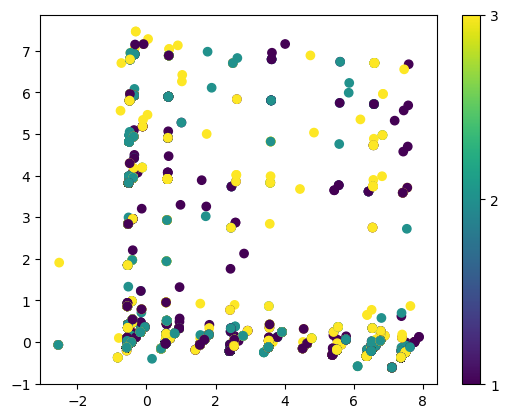

In [8]:
# First Question: How does the weather impact the serverity of the accident?
""" weather_conditions = ["Weather_Conditions", "Road_Surface_Conditions",
                      "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"]
accident_data = data_frames["accidents"][weather_conditions]
# Remove all nan rows (only for longitude and latitude)
accident_data = accident_data.dropna().values
num_features = int(accident_data.shape[0] * 0.1)
accident_data = accident_data[:num_features]
"""
X = accident_data[:, :-1]
y = accident_data[:, -1]

plot_ftrs(X, y, dimensions=2)

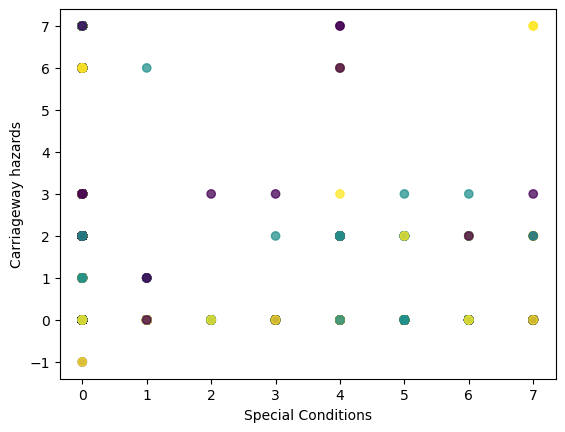

In [9]:
plt.scatter(accident_data[:, 2], accident_data[:, 3], c=y, cmap="viridis", alpha=0.75)
plt.xlabel("Special Conditions")
plt.ylabel("Carriageway hazards")
plt.show()

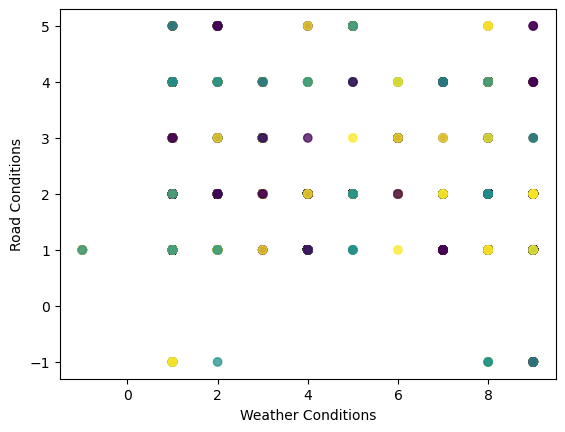

In [10]:
plt.scatter(accident_data[:, 0], accident_data[:, 1], c=y, cmap="viridis", alpha=0.75)
plt.xlabel("Weather Conditions")
plt.ylabel("Road Conditions")
plt.show()

In [11]:
accident_pipe = Pipeline([("scaler", SS()), ("svc", SVC(kernel="linear"))])
fit_predict(accident_pipe, tts(X, y, test_size=0.3), params={"C": [0.0001, 0.001, 0.01, 0.1, 1]})

Fitting C = 0.0001
Accuracy = 92.497%
Fitting C = 0.001
Accuracy = 91.638%
Fitting C = 0.01
Accuracy = 91.645%
Fitting C = 0.1
Accuracy = 91.649%
Fitting C = 1
Accuracy = 91.646%

Fitting hyperparameter C over 5 params took 15.502 minutes
